# Your Mission, should you choose to accept it...

To hyperparameter tune and extract every ounce of accuracy out of this telecom customer churn dataset: <https://drive.google.com/file/d/1dfbAsM9DwA7tYhInyflIpZnYs7VT-0AQ/view> 

## Requirements

- Load the data
- Clean the data if necessary (it will be)
- Create and fit a baseline Keras MLP model to the data.
- Hyperparameter tune (at least) the following parameters:
 - batch_size
 - training epochs
 - optimizer
 - learning rate (if applicable to optimizer)
 - momentum (if applicable to optimizer)
 - activation functions
 - network weight initialization
 - dropout regularization
 - number of neurons in the hidden layer
 
 You must use Grid Search and Cross Validation for your initial pass of the above hyperparameters
 
 Try and get the maximum accuracy possible out of this data! You'll save big telecoms millions! Doesn't that sound great?


## First Look at the Data

In [85]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [86]:
df = pd.read_csv('telecomm.csv')
print(df.shape)
df.head()

(7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [87]:
# Distribution of target data

df['Churn'].value_counts(normalize=True)

No     0.73463
Yes    0.26537
Name: Churn, dtype: float64

In [88]:
# turn the taget into numbers representing yes and no

df['Churn'] = df['Churn'].replace({'Yes':1, 'No':0})

In [89]:
# Check the Cardinality of each feature
for column in df.columns:
    print(column+':  ',df[column].nunique())

customerID:   7043
gender:   2
SeniorCitizen:   2
Partner:   2
Dependents:   2
tenure:   73
PhoneService:   2
MultipleLines:   3
InternetService:   3
OnlineSecurity:   3
OnlineBackup:   3
DeviceProtection:   3
TechSupport:   3
StreamingTV:   3
StreamingMovies:   3
Contract:   3
PaperlessBilling:   2
PaymentMethod:   4
MonthlyCharges:   1585
TotalCharges:   6531
Churn:   2


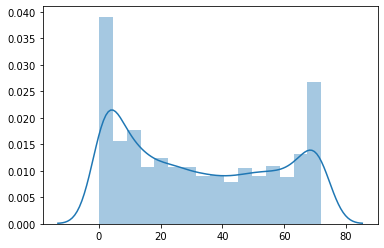

In [90]:
sns.distplot(df[['tenure']])

I want to check the cardinality of each feature. It looks like I have mostly low cardinality data with a few continuous features. I'll need to do some ordinal encoding and Scaling. That can all be put together in a pipeline and run through the Grid Search with a multi-layer Perceptron.

## Modeling

In [243]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from xgboost import XGBClassifier

from keras.models import Sequential
from keras.layers import Dense

from keras.wrappers.scikit_learn import KerasClassifier

import category_encoders as ce

In [244]:
X = df.drop(columns=['Churn', 'customerID']).values
y = df['Churn'].values

In [245]:
def ghetto_pipe(tts=False, X=X, y=y):
    """Create a pipline to quickly manipulate data"""
    
    ord_enc = ce.OrdinalEncoder()
    scaler  = StandardScaler()


    X = ord_enc.fit_transform(X)
    X = scaler.fit_transform(X)
    
    
    if tts==True:
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                            test_size=0.3, 
                                                            random_state=42)

        return X_train, X_test, y_train, y_test
    
    else:
        
        return X, y

In [246]:
X_train, X_test, y_train, y_test = ghetto_pipe(tts=True)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4930, 19), (2113, 19), (4930,), (2113,))

In [247]:
X, y = ghetto_pipe()

X.shape, y.shape

((7043, 19), (7043,))

### Establish a Baseline

I want something to compare the performance of the MLP with. I'll be breaking out a Gradient Boosting Tree Ensemble to run a classification with. 

In [248]:
xgbc    = XGBClassifier(base_score=0.4, booster='gbtree', colsample_bylevel=1,
                        colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
                        max_depth=17, min_child_weight=1, missing=None, n_estimators=100,
                        n_jobs=-1, nthread=None, objective='binary:logistic',random_state=42, 
                        reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42, 
                        silent=True, subsample=1, eval_metric='error')

xgbc.fit(X, y)

print(cross_val_score(xgbc, X, y, cv = 5, scoring = 'accuracy',
                      n_jobs = -1, verbose = 0).mean())

0.7802067428244562


In [249]:
# Define model function for Keras Classifier Object
def create_model():
    # create model
    model = Sequential()
    # Input and First Hidden Layer
    model.add(Dense(32, input_dim=X.shape[1], activation='relu'))
    # Second Hidden Layer
    model.add(Dense(16, activation='relu'))
    # Output Layer
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', 
                  optimizer='adam', 
                  metrics=['accuracy'])

    return model

model = KerasClassifier(build_fn=create_model, verbose=1)

In [255]:
%%time

# Define the grid search parameters
param_grid = {'batch_size': [10, 40, 80, 100],
              'epochs': np.arange(5,41)}

# Create Grid Search
grid = GridSearchCV(estimator=model, 
                    param_grid=param_grid,
                    cv=5,
                    n_jobs=-1)

grid_result = grid.fit(X, y, verbose=0)

# Report Results
print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f"Means: {mean}, Stdev: {stdev} with: {param}")

Best: 0.8061905434299866 using {'batch_size': 40, 'epochs': 15}
Means: 0.7985233530459308, Stdev: 0.006031576690396276 with: {'batch_size': 10, 'epochs': 5}
Means: 0.8046287061154935, Stdev: 0.0040691759810969315 with: {'batch_size': 10, 'epochs': 6}
Means: 0.7986653388079706, Stdev: 0.007583987546990879 with: {'batch_size': 10, 'epochs': 7}
Means: 0.8037767964263844, Stdev: 0.0039817723579041115 with: {'batch_size': 10, 'epochs': 8}
Means: 0.8002271731435009, Stdev: 0.007838815737788128 with: {'batch_size': 10, 'epochs': 9}
Means: 0.7968195348948423, Stdev: 0.0014438747287277554 with: {'batch_size': 10, 'epochs': 10}
Means: 0.8006531277553239, Stdev: 0.005009287761089869 with: {'batch_size': 10, 'epochs': 11}
Means: 0.8027829017538282, Stdev: 0.005768278479146024 with: {'batch_size': 10, 'epochs': 12}
Means: 0.7966775494036172, Stdev: 0.006480245129029531 with: {'batch_size': 10, 'epochs': 13}
Means: 0.7907141820707054, Stdev: 0.005116399103415604 with: {'batch_size': 10, 'epochs': 14

#### How'd it do?

**Wall time: 28min 45s**

Woof

##### Model performance is slightly better than gradient boosting. That's nice. 

In [256]:
# I want to look at the loss functions

best_batch = grid_result.best_params_['batch_size']
best_epoch = grid_result.best_params_['epochs']

optimal_model = create_model()

opt = optimal_model.fit(X, y,
                        epochs=best_epoch,
                        batch_size=best_batch,
                        validation_split=.2,
                        verbose=1)

Train on 5634 samples, validate on 1409 samples
Epoch 1/15
5634/5634 [==============================] - 3s 464us/step - loss: 0.5133 - acc: 0.7435 - val_loss: 0.4614 - val_acc: 0.7708
Epoch 2/15
5634/5634 [==============================] - 0s 59us/step - loss: 0.4329 - acc: 0.7932 - val_loss: 0.4484 - val_acc: 0.7835
Epoch 3/15
5634/5634 [==============================] - 0s 57us/step - loss: 0.4224 - acc: 0.8026 - val_loss: 0.4390 - val_acc: 0.7963
Epoch 4/15
5634/5634 [==============================] - 0s 57us/step - loss: 0.4172 - acc: 0.8056 - val_loss: 0.4375 - val_acc: 0.8034
Epoch 5/15
5634/5634 [==============================] - 0s 57us/step - loss: 0.4129 - acc: 0.8080 - val_loss: 0.4334 - val_acc: 0.8027
Epoch 6/15
5634/5634 [==============================] - 0s 59us/step - loss: 0.4112 - acc: 0.8078 - val_loss: 0.4306 - val_acc: 0.8006
Epoch 7/15
5634/5634 [==============================] - 0s 57us/step - loss: 0.4085 - acc: 0.8094 - val_loss: 0.4289 - val_acc: 0.8013
Epoch 

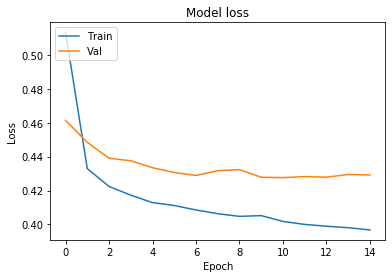

In [257]:
# Plot training & validation loss values
plt.plot(opt.history['loss'])
plt.plot(opt.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [258]:
optimal_model.fit(X_train, y_train,
                 epochs=best_epoch,
                 batch_size=best_batch,
                 verbose=1)

Epoch 1/15
4930/4930 [==============================] - 0s 56us/step - loss: 0.4071 - acc: 0.8134
Epoch 2/15
4930/4930 [==============================] - 0s 55us/step - loss: 0.4058 - acc: 0.8103
Epoch 3/15
4930/4930 [==============================] - 0s 55us/step - loss: 0.4031 - acc: 0.8154
Epoch 4/15
4930/4930 [==============================] - 0s 53us/step - loss: 0.4017 - acc: 0.8138
Epoch 5/15
4930/4930 [==============================] - 0s 56us/step - loss: 0.4005 - acc: 0.8168
Epoch 6/15
4930/4930 [==============================] - 0s 51us/step - loss: 0.3982 - acc: 0.8162
Epoch 7/15
4930/4930 [==============================] - 0s 48us/step - loss: 0.3975 - acc: 0.8174
Epoch 8/15
4930/4930 [==============================] - 0s 51us/step - loss: 0.3961 - acc: 0.8140
Epoch 9/15
4930/4930 [==============================] - 0s 54us/step - loss: 0.3949 - acc: 0.8174
Epoch 10/15
4930/4930 [==============================] - 0s 46us/step - loss: 0.3947 - acc: 0.8189
Epoch 11/15
4930/49

In [259]:
scores = optimal_model.evaluate(X_test, y_test)

print('Neural Network ACC: ', scores[1])

2113/2113 [==============================] - 0s 63us/step
Neural Network ACC:  0.807382867960246


## Other Strategies

So that was computationally expensive and established a couple things

- low epoch and batch size are optimal
- the training data is overfitting compared to the validation data


Therefore the next steps are:

- Apply Dropout Layers to prevent overfitting
- Random Search CV with lots of hyper-parameter (TURN ALL THE KNOBS!)
- Bayes SMBO on the narrowed down section

In [260]:
from keras.layers import Dropout
from keras.optimizers import SGD
from keras.optimizers import Adam

In [277]:
# Define model function for Keras Classifier Object
def create_drop_model():
    # create model
    model = Sequential()
    # Input and First Dropout Layer
    model.add(Dropout(0.3, input_dim=X.shape[1]))
    # Second Hidden Layer
    model.add(Dense(32, activation='relu'))
    # Second Dropout
    model.add.Dropout(0.3)
    # Second Hidden Layer
    model.add(Dense(16, activation='relu'))
    # Second Dropout
    model.add.Dropout(0.3)
    # Third Hidden Layer
    model.add(Dense(16, activation='relu'))
    # Output Layer
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    
    sgd = SGD(lr=0.0001, momentum=0.5, decay=0, nesterov=False)
    adam = Adam(lr=0.0000001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=10, amsgrad=False)

    
    
    model.compile(loss='binary_crossentropy', 
                  optimizer='adam', 
                  metrics=['accuracy'])

    return model

drop_model = KerasClassifier(build_fn=create_model, verbose=1)

In [278]:
d_model = drop_model.fit(X, y,
                         epochs=100,
                         batch_size=best_batch,
                         validation_split=.2,
                         verbose=1)

Train on 5634 samples, validate on 1409 samples
Epoch 1/100
5634/5634 [==============================] - 3s 521us/step - loss: 0.4801 - acc: 0.7561 - val_loss: 0.4527 - val_acc: 0.7800
Epoch 2/100
5634/5634 [==============================] - 0s 65us/step - loss: 0.4306 - acc: 0.7945 - val_loss: 0.4457 - val_acc: 0.7956
Epoch 3/100
5634/5634 [==============================] - 0s 64us/step - loss: 0.4221 - acc: 0.8007 - val_loss: 0.4388 - val_acc: 0.8006
Epoch 4/100
5634/5634 [==============================] - 0s 69us/step - loss: 0.4171 - acc: 0.8030 - val_loss: 0.4401 - val_acc: 0.7977
Epoch 5/100
5634/5634 [==============================] - 0s 71us/step - loss: 0.4128 - acc: 0.8072 - val_loss: 0.4358 - val_acc: 0.7977
Epoch 6/100
5634/5634 [==============================] - 0s 72us/step - loss: 0.4110 - acc: 0.8051 - val_loss: 0.4402 - val_acc: 0.7963
Epoch 7/100
5634/5634 [==============================] - 0s 56us/step - loss: 0.4085 - acc: 0.8067 - val_loss: 0.4404 - val_acc: 0.7949

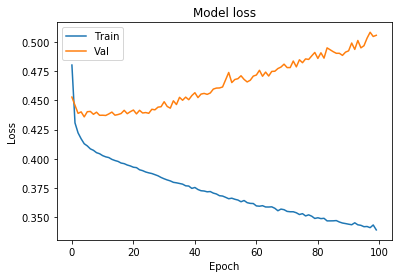

In [279]:
# Plot training & validation loss values
plt.plot(d_model.history['loss'])
plt.plot(d_model.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

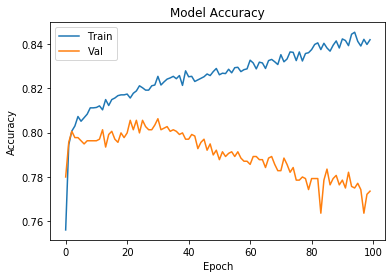

In [280]:
plt.plot(d_model.history['acc'])
plt.plot(d_model.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

## On Overfitting

There is an exceptional amount of overfitting in this dataset. After applying overfitting prevention measures such as dropout layers and max feature weights, I have found that it still does not decrease overfitting. 

I am going to move on to some Random Searches and Bayes Searches

## Better Searching


#### Random Search

In [290]:
import random

from sklearn.model_selection import RandomizedSearchCV

In [296]:
# Define model function for Keras Classifier Object
def r_create_model():
    # create model
    model = Sequential()
    # Input and First Hidden Layer
    model.add(Dense(32, input_dim=X.shape[1], activation='relu'))
    # Second Hidden Layer
    model.add(Dense(16, activation='relu'))
    # Output Layer
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', 
                  optimizer='adam', 
                  metrics=['accuracy'])

    return model

In [298]:
# Specify parameters and distributions to sample from

ranges = random.randint(1, 100)

r_model = KerasClassifier(build_fn=r_create_model()) 



# Prepare the Dict for the Search
param_grid = {'batch_size': [ranges],
              'epochs': [ranges]}

# Search in action!
n_iter_search = 50 # Number of parameter settings that are sampled.
random_search = RandomizedSearchCV(estimator=r_model, 
                                   param_distributions=param_grid,
                                   n_iter=n_iter_search,
                                   n_jobs=-1, 
                                   cv=3, 
                                   verbose=0)
random_search.fit(X, y, verbose=0)

/anaconda3/envs/U4-S2-NNF/lib/python3.7/site-packages/sklearn/model_selection/_search.py:266: UserWarning: The total space of parameters 1 is smaller than n_iter=50. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


TypeError: __call__() missing 1 required positional argument: 'inputs'

In [ ]:
print("Best: %f using %s" % (random_search.best_score_, random_search.best_params_))
means = random_search.cv_results_['mean_test_score']
stds = random_search.cv_results_['std_test_score']
params = random_search.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
param_grid = {'batch_size': [10, 40, 80, 100],
              'epochs': np.arange(5,41)}

In [ ]:
ranges

#### Bayes Search

In [ ]:
def model(x_train, y_train, x_test, y_test):
    """
    Model providing function:
    Create Keras model with double curly brackets dropped-in as needed.
    Return value has to be a valid python dictionary with two customary keys:
        - loss: Specify a numeric evaluation metric to be minimized
        - status: Just use STATUS_OK and see hyperopt documentation if not feasible
    The last one is optional, though recommended, namely:
        - model: specify the model just created so that we can later use it again.
    """
    # Model definition / hyperparameters space definition / fit / eval
    return {'loss': <metrics_to_minimize>, 'status': STATUS_OK, 'model': model}
    
# SMBO - TPE in action
best_run, best_model = optim.minimize(model=model,
                                      data=data,
                                      algo=tpe.suggest,
                                      max_evals=,
                                      trials=Trials())

# Show the results
x_train, y_train, x_test, y_test = data()
print("Evalutation of best performing model:")
print(best_model.evaluate(x_test, y_test))
print("Best performing model chosen hyper-parameters:")
print(best_run)


## Optimal Results So Far

Best: 0.8040607704470378 using {'batch_size': 80, 'epochs': 20}  
Means: 0.7929859406295088, Stdev: 0.0050868434251242324 with: {'batch_size': 10, 'epochs': 20}  
Means: 0.7841828748547826, Stdev: 0.004574725245476072 with: {'batch_size': 10, 'epochs': 40}  
Means: 0.7709782742800638, Stdev: 0.004439631862406806 with: {'batch_size': 10, 'epochs': 60}  
Means: 0.7481186994601765, Stdev: 0.014687760496656183 with: {'batch_size': 10, 'epochs': 80}  
Means: 0.7535141274093922, Stdev: 0.01231773249945592 with: {'batch_size': 10, 'epochs': 100}  
Means: 0.7972454958369612, Stdev: 0.002275440428439996 with: {'batch_size': 20, 'epochs': 20}  
Means: 0.7951157203405127, Stdev: 0.001774766578799858 with: {'batch_size': 20, 'epochs': 40}  
Means: 0.7770836329267189, Stdev: 0.007344774891189583 with: {'batch_size': 20, 'epochs': 60}  
Means: 0.7611813153941981, Stdev: 0.03101368767227507 with: {'batch_size': 20, 'epochs': 80}  
Means: 0.7760897362145887, Stdev: 0.007283950570171593 with: {'batch_size': 20, 'epochs': 100}  
Means: 0.7921340332169365, Stdev: 0.007475974825565626 with: {'batch_size': 40, 'epochs': 20}  
Means: 0.7847508166588861, Stdev: 0.002943371335911798 with: {'batch_size': 40, 'epochs': 40}  
Means: 0.7875905151514782, Stdev: 0.0053183814912085535 with: {'batch_size': 40, 'epochs': 60}  
Means: 0.7796393574917501, Stdev: 0.0041321261563522695 with: {'batch_size': 40, 'epochs': 80}  
Means: 0.7704103369528675, Stdev: 0.009448314862501705 with: {'batch_size': 40, 'epochs': 100}  
Means: 0.7973874806172974, Stdev: 0.004173928322933939 with: {'batch_size': 60, 'epochs': 20}  
Means: 0.7936958713861888, Stdev: 0.0031359798707445976 with: {'batch_size': 60, 'epochs': 40}  
Means: 0.7850347872943545, Stdev: 0.003966179840889809 with: {'batch_size': 60, 'epochs': 60}  
Means: 0.777793553273955, Stdev: 0.01114478472726149 with: {'batch_size': 60, 'epochs': 80}  
Means: 0.7775095888587642, Stdev: 0.00410444462927118 with: {'batch_size': 60, 'epochs': 100}  
Means: 0.8040607704470378, Stdev: 0.0031301428363589303 with: {'batch_size': 80, 'epochs': 20}  
Means: 0.7884424258815317, Stdev: 0.002135210315354395 with: {'batch_size': 80, 'epochs': 40}  
Means: 0.7884424278872537, Stdev: 0.006407064062731743 with: {'batch_size': 80, 'epochs': 60}  
Means: 0.78176913067781, Stdev: 0.010360357463175521 with: {'batch_size': 80, 'epochs': 80}  
Means: 0.781343177394672, Stdev: 0.00234826967736232 with: {'batch_size': 80, 'epochs': 100}  
Means: 0.7985233514887458, Stdev: 0.0031799430943520134 with: {'batch_size': 100, 'epochs': 20}  
Means: 0.7955416695445027, Stdev: 0.01046966778426854 with: {'batch_size': 100, 'epochs': 40}  
Means: 0.7871645558680997, Stdev: 0.0025503891559041304 with: {'batch_size': 100, 'epochs': 60}  
Means: 0.7891523483445084, Stdev: 0.002855865078888857 with: {'batch_size': 100, 'epochs': 80}  
Means: 0.7790714143420355, Stdev: 0.009488870729254707 with: {'batch_size': 100, 'epochs': 100}  
CPU times: user 2.96 s, sys: 314 ms, total: 3.27 s  
Wall time: 6min 29s


19

## Stretch Goals:

- Try to implement Random Search Hyperparameter Tuning on this dataset
- Try to implement Bayesian Optimiation tuning on this dataset
- Practice hyperparameter tuning other datasets that we have looked at. How high can you get MNIST? Above 99%?
- Study for the Sprint Challenge
 - Can you implement both perceptron and MLP models from scratch with forward and backpropagation?
 - Can you implement both perceptron and MLP models in keras and tune their hyperparameters with cross validation?